# Cassava classification

### Import the required libraries

In [37]:
from collections import defaultdict
import copy
import random
import numpy as np
import os
import shutil
from urllib.request import urlretrieve
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
cudnn.benchmark = True
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import timm
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy, JsdCrossEntropy
from utils import Mixup, RandAugment, RAdam
from PIL import Image
SEED = 42

In [38]:
def seed_everything(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(SEED)

In [39]:
torch.__version__
os.environ['CUDA_VISIBLE_DEVICES'] ="1"

### Set the root directory dataset

In [40]:
root = os.path.join(os.environ["HOME"], "Workspace/datasets/taiyoyuden/cassava")

### Split files from the dataset into the train and validation sets

Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 20000 images for training, 4936 images for validation, and 10 images for testing.

In [41]:
os.listdir(root)

['test_images',
 'label_num_to_disease_map.json',
 'train_1_pseudo.csv',
 'val_1_pseudo.csv',
 'external',
 'sample_submission.csv',
 'train_images',
 'label_num_to_disease_map.json.save',
 'train.csv']

### Define a function to visualize images and their labels

Let's define a function that will take a list of images' file paths and their labels and visualize them in a grid. Correct labels are colored green, and incorrectly predicted labels are colored red.

In [42]:
train = pd.read_csv(f'{root}/train.csv')
train_external = pd.read_csv(f'{root}/external/train_external.csv')
test_external = pd.read_csv(f'{root}/external/test_external.csv')
test_external_pseudo = pd.read_csv(f'{root}/external/test_external_pseudo.csv')
test = pd.read_csv(f'{root}/sample_submission.csv')
label_map = pd.read_json(f'{root}/label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)
display(test_external.head())


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4
1,1000015157.jpg,0
2,1000201771.jpg,3


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


,image_id,label
0,extra-image-10000.jpg,1
1,extra-image-10001.jpg,1
2,extra-image-10002.jpg,1
3,extra-image-10004.jpg,1
4,extra-image-10005.jpg,1


In [43]:
label_map.iloc[1].values
np.random.randint(50, 10000, 50)

array([7320,  910, 5440, 5241, 5784, 6315,  516, 4476, 5628, 8372, 1735,
        819, 6999, 2483, 5361, 5101, 6470, 1234, 4605, 3435, 6446, 8716,
       9324, 2608, 7899, 2097, 2797, 9217,  239, 2784, 3055, 4708, 1949,
       7784, 1317, 1578, 3606, 3940, 8888, 5443, 8842, 8483, 7563, 2662,
       7091, 9605, 6285, 5536, 7149, 9720])

In [44]:
def visualize_input_image_grid(filepaths, image_name, labels, cols=4):
    rows = 5
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25, 15))
    for i, index in enumerate(np.random.randint(0, len(image_name), 20)):
        name = image_name.iloc[index]['image_id']
        label =  image_name.iloc[index]['label']
        image = cv2.imread(f'{filepaths}/train_images/{name}')
        if (i == 0): 
            print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(label, color='GREEN')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [45]:
def visualize_class_dis(df, fold, color='maroon'):
    x = df.groupby('label').count()
    try:
        x_p = df.groupby('pred').count()
    except:
        x_p = None
    y = [0,1,2,3,4]

    fig = plt.figure(figsize=(10,5))
    plt.bar(y, x['image_id'].values, color = color, width = 0.4)
    plt.xlabel("Label") 
    plt.ylabel("Number of image") 
    plt.title(f"Class distribution of data fold: {fold}") 
    
    if x_p is not None:
        fig = plt.figure(figsize=(10,5))
        plt.bar(y, x_p['image_id'].values, color = 'maroon', width = 0.4)
        plt.xlabel("Label") 
        plt.ylabel("Number of image") 
        plt.title(f"Class distribution of data fold: {fold}") 

    # plt.xticks(x['image_id'])
    plt.show()

### Define the parameters of the whole process 

In [1]:
models_name = ["resnest26d","resnest50d", "skresnet50", "tf_efficientnet_b3_ns", "vit_base_patch16_384"]
WEIGHTS = [

#         "./weights/resnest26d/resnest26d_fold0_best_epoch_4_final_2nd.pth",
        "./weights/resnest26d/resnest26d_fold1_best_epoch_7_final_2nd.pth",
        "./weights/resnest26d/resnest26d_fold2_best_epoch_4_final_2nd.pth",
#         "./weights/resnest26d/resnest26d_fold3_best_epoch_58.pth",
#         "./weights/resnest26d/resnest26d_fold4_best_epoch_21_final_2nd.pth",
#         #
        
#         "./weights/tf_efficientnet_b3_ns/tf_efficientnet_b3_ns_fold1_best_epoch_19_external.pth", 
        "./weights/tf_efficientnet_b3_ns/tf_efficientnet_b3_ns_fold1_best_epoch_1_final_512.pth",
#         "./weights/tf_efficientnet_b3_ns/tf_efficientnet_b3_ns_fold1_best_epoch_26_512.pth",

    
        #"./weights/resnest50d/resnest50d_fold0_best_epoch_30_final_1st.pth",
        # "./weights/resnest50d/resnest50d_fold0_best_epoch_13_final_2nd.pth",
        "./weights/resnest50d/resnest50d_fold0_best_epoch_10_final_3rd.pth",
        # "./weights/resnest50d/resnest50d_fold1_best_epoch_95_final_1st.pth",
        "./weights/resnest50d/resnest50d_fold1_best_epoch_17_final_2nd.pth",
        "./weights/resnest50d/resnest50d_fold1_best_epoch_8_final_5th_pseudo.pth",
        # "./weights/resnest50d/resnest50d_fold2_best_epoch_50_final_1st.pth",
        "./weights/resnest50d/resnest50d_fold2_best_epoch_22_final_2nd.pth",
        # "./weights/resnest50d/resnest50d_fold3_best_epoch_2_final_2nd.pth",
        "./weights/resnest50d/resnest50d_fold3_best_epoch_1_final_3rd.pth",
        # "./weights/resnest50d/resnest50d_fold4_best_epoch_10_final_2nd.pth",
        "./weights/resnest50d/resnest50d_fold4_best_epoch_15_final_3rd.pth" ,
        "./weights/resnest50d/resnest50d_fold4_best_epoch_1_final_5th_pseudo.pth",
        "./weights/resnest50d/resnest50d_fold4_best_epoch_10_final-4th.pth"
          #

]
# Single model
model_index = 1
ckpt_index = 0

# kfold
fold_model_index = 1
fold_ckpt_index = [0,1,2,3,4] 
fold_ckpt_weight = [1,1,1,1,1]

# Ensemble
ensemble_models_name = list(2*["resnest26d"] + ["tf_efficientnet_b3_ns"] + 8*["resnest50d"])
ensemble_ckpt_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

params = {
    "train_phase":False,
    "visualize": False,
    "fold": 4,
    "train_external": True,
    "test_external": False,
    "load_pretrained": True,
    "balance_data":False,
    "resume": False,
    "image_size": 480,
    "num_classes": 5,
    "model": models_name[model_index],
    "device": "cuda",
    "lr": 1e-4,
    "lr_min":1e-7,
    "batch_size": 8,
    "num_workers": 8,
    "epochs": 100,
    "gradient_accumulation_steps": 8,
    "drop_block": 0.2,
    "drop_rate": 0.2,
    "mix_up": True,
    "cutmix":True,
    "rand_aug": False,
    "local_rank":0,
    "distributed": False,
    "hard_negative_sample": False,
    "tta": True,
    "crops_tta":False,
    "kfold_pred":True,
    "ensemble": False,
    "error_analysis":False,
    "create_pseudo": True
    
}

### Define dataset with KFolds strategy

In [2]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['label'])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
###
fold = params["fold"]
train_idx = folds[folds['fold'] != fold].index
val_idx = folds[folds['fold'] == fold].index

train_folds = folds.loc[train_idx].reset_index(drop=True)
val_folds = folds.loc[val_idx].reset_index(drop=True)

NameError: name 'train' is not defined

In [87]:
# Dataset
class TrainDataset(Dataset):
    def __init__(self, df, transform=None, mosaic_mix = False):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        self.mosaic_mix = mosaic_mix
        self.rand_aug_fn = RandAugment()
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{root}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = torch.tensor(self.labels[idx]).long()
        if params["rand_aug"]:
            image = np.array(self.rand_aug_fn(Image.fromarray(image)))
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label, file_name
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None, valid_test=False, fcrops=False):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        self.valid_test = valid_test
        self.fcrops = fcrops
        if self.valid_test:
            self.labels = df['label'].values  
        else:
            assert ValueError("Test data does not have annotation, plz check!")
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        if self.valid_test:
            file_path = f'{root}/train_images/{file_name}'
#             file_path = f'{root}/external/extraimages/{file_name}'
        else:
            file_path = f'{root}/test_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if isinstance(self.transform, list):
            outputs = {'images':[],
                       'labels':[],
                       'image_ids':[]}
            if self.fcrops:
                for trans in self.transform:
                    image_aug = Image.open(file_path)
                    image_aug = trans(image_aug)
                    outputs["images"].append(image_aug)
                    del image_aug
            else:
                for trans in self.transform:
                    augmented = trans(image=image)
                    image_aug = augmented['image']
                    outputs["images"].append(image_aug)
                    del image_aug

            if self.valid_test:
                label = torch.tensor(self.labels[idx]).long()
                outputs['labels'] = len(self.transform)*[label]
                outputs['image_ids'].append(file_name)
                
            else:
                outputs['labels'] = len(self.transform)*[-1]
                
            return outputs
        else:
            augmented = self.transform(image=image)
            image = augmented['image'] 
        return image

### Use Albumentations to define transformation functions for the train and validation datasets

In [88]:
train_transform = A.Compose(
    [
        A.RandomResizedCrop(height=params["image_size"], width=params["image_size"], p=1),
        A.OneOf([
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),], p=1.
        ),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.IAAAffine(rotate=0.2, shear=0.2,p=0.5),
        A.CoarseDropout(max_holes=20, max_height=int(params["image_size"]/15), max_width=int(params["image_size"]/15), p=0.5),
#         A.IAAAdditiveGaussianNoise(p=1.),
        A.MedianBlur(p=0.5),
        A.Equalize(p=0.2),
        A.GridDistortion(p=0.2),
#         A.RandomGridShuffle(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_transform = A.Compose(
    [
        A.CenterCrop(height=params["image_size"], width=params["image_size"], p=1),
        A.Resize(params["image_size"],params["image_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
if params["cutmix"]:
    mixup_fn = Mixup(mixup_alpha=1., cutmix_alpha=1., label_smoothing=0.1, num_classes=params["num_classes"])
else:
    mixup_fn = Mixup(mixup_alpha=1., label_smoothing=0.1, num_classes=params["num_classes"])

val_dataset = TrainDataset(val_folds, transform=val_transform)

In [89]:
transform_tta0 = A.Compose(
    [
     A.CenterCrop(height=params["image_size"], width=params["image_size"], p=1),    
     A.Resize(height=params["image_size"], width=params["image_size"], p=1),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),   
     ToTensorV2()
    ]
)

transform_tta1 = A.Compose(
    [
     A.CenterCrop(height=params["image_size"], width=params["image_size"], p=1),
     A.Resize(height=params["image_size"], width=params["image_size"], p=1),
     A.HorizontalFlip(p=1.),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),   
     ToTensorV2()
    ]
)
transform_tta2 = A.Compose(
    [
     A.CenterCrop(height=params["image_size"], width=params["image_size"], p=1),
     A.Resize(height=params["image_size"], width=params["image_size"], p=1),
     A.VerticalFlip(p=1.),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2(),
    ]
)
transform_tta3 = A.Compose(
    [
     A.CenterCrop(height=params["image_size"], width=params["image_size"], p=1),
     A.Resize(height=params["image_size"], width=params["image_size"], p=1),
     A.RandomRotate90(p=1.),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),     
     ToTensorV2(),
    ]
)

##### Test TTA with Five Crops
transform_crop_tta0 = T.Compose([
                T.FiveCrop(params["image_size"]),
                T.Lambda(lambda crops: ([T.ToTensor()(crop) for crop in crops])),
                T.Lambda(lambda norms: torch.stack([T.Normalize(mean=[0.5], std=[0.5])(norm) for norm in norms]))
        ]
)
    
transform_crop_tta1 = T.Compose([
                T.FiveCrop(params["image_size"]),
                T.Lambda(lambda crops: ([T.ToTensor()(crop) for crop in crops])),
                T.Lambda(lambda flips: ([T.RandomHorizontalFlip(p=1.)(flip) for flip in flips])),
                T.Lambda(lambda norms: torch.stack([T.Normalize(mean=[0.5], std=[0.5])(norm) for norm in norms]))
    ]
)
transform_crop_tta2 = T.Compose([
                T.FiveCrop(params["image_size"]),
                T.Lambda(lambda crops: ([T.ToTensor()(crop) for crop in crops])),
                T.Lambda(lambda flips: ([T.RandomVerticalFlip(p=1.)(flip) for flip in flips])),
                T.Lambda(lambda norms: torch.stack([T.Normalize(mean=[0.5], std=[0.5])(norm) for norm in norms]))
    ]
)
test_transform_tta = [transform_tta0, transform_tta1, transform_tta2, transform_tta3]
test_transform_tta_crops = [transform_crop_tta0, transform_crop_tta1, transform_crop_tta2]

Also let's define a function that takes a dataset and visualizes different augmentations applied to the same image.

In [90]:
def calculate_accuracy(output, target):
#     return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
    if params["mix_up"]:
        output = torch.argmax(torch.softmax(output, dim=1), dim=1)
        return accuracy_score(output.cpu(), target.argmax(1).cpu())
    
    output = torch.softmax(output, dim=1)
    return accuracy_score(output.argmax(1).cpu(), target.cpu())

In [91]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()
        self.curr_acc = 0.
    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]
        self.curr_acc = metric["avg"]
    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [92]:
def declare_model(name, index=None):
    model = timm.create_model(name,
            pretrained=False,
            num_classes=params["num_classes"],
            drop_rate=params["drop_rate"])
    model = model.to(params["device"])
    
    if params["distributed"]:
        assert ValueError("No need to implement in a single machine")
    else:
        model = torch.nn.DataParallel(model) 
        
    if params["load_pretrained"]:
        if index == None: 
            return model
        state_dict = torch.load(WEIGHTS[index])
        print(f"Load pretrained model: {name} ",state_dict["preds"])
        model.load_state_dict(state_dict["model"])
        best_acc = state_dict["preds"]   
    return model
if not params["kfold_pred"]:
    model = declare_model(params["model"], ckpt_index)
val_criterion = nn.CrossEntropyLoss().to(params["device"])

--------------------------------------------------------------------------------
## Make validation prediction w/TTA on validation and test set

In [93]:
train_dataset = TestDataset(train_folds, transform=test_transform_tta, valid_test=True)
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
if params["tta"]:
    val_pred_dataset = TestDataset(val_folds, transform=test_transform_tta, valid_test=True)
    test_pred_dataset = TestDataset(test, transform=test_transform_tta)
else:
    val_pred_dataset = TestDataset(val_folds, transform=val_transform, valid_test=True)
    test_pred_dataset = TestDataset(test, transform=val_transform)

val_pred_dataset_crops = TestDataset(val_folds, transform=test_transform_tta_crops,valid_test=True, fcrops=True)


In [94]:
val_pred_loader = DataLoader(
    val_pred_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=2, pin_memory=True,
)
val_pred_loader_crop = DataLoader(
    val_pred_dataset_crops, batch_size=params['batch_size'], shuffle=False, num_workers=2, pin_memory=True,
)
test_pred_loader = DataLoader(
    test_pred_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=2, pin_memory=True,
)

In [95]:
def visualize_tta(data, pred):     
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    if params["tta"]:
        figure, ax = plt.subplots(nrows=1, ncols=num_tta, figsize=(12, 6))
        for i, image in enumerate(data["images"]):
            image = (unorm(image[0]).cpu().numpy()*255).astype(int)
            ax.ravel()[i].imshow(image.transpose(2,1,0))
            ax.ravel()[i].set_title(str(pred), color='GREEN')
            ax.ravel()[i].set_axis_off()
        plt.tight_layout()
        plt.show() 
    else:
        image = (unorm(data).cpu().numpy()*255).astype(int)
        imgplot = plt.imshow(image[0].transpose(2,1,0))
        imgplot = plt.title(str(pred), color='GREEN')
        plt.show()

In [96]:
def validate(val_loader, model, criterion, epoch, params, fold, best_acc):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target, _) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)#.view(-1,params['batch_size'])
            output = model(images)
            loss = val_criterion(output, target)
            output = torch.softmax(output, dim = 1)
            
            accuracy = accuracy_score(output.argmax(1).cpu(), target.cpu())

            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )           
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
        #to save weight
        if (metric_monitor.curr_acc > best_acc): # or epoch == params["epochs"]:
            print(f"Save best weight at acc {round(metric_monitor.curr_acc,4)}, epoch: {epoch}")
            torch.save({'model': model.state_dict(), 
                'preds': round(metric_monitor.curr_acc,4)},
                 f'weights/{params["model"]}_fold{fold}_best_epoch_{epoch}.pth')

            best_acc = metric_monitor.curr_acc
    return best_acc

In [97]:
def gmean(input_x, dim):
    log_x = torch.log(input_x)
    return torch.exp(torch.mean(log_x, dim=dim))
from scipy.stats.mstats import gmean as scigmean  

In [98]:
def tta_validate(loader, model, params, valid_test=False):
    num_tta = len(test_transform_tta)
    incorrect_pred_list = {'image_id':[],
                       'label':[],
                       'pred':[],
                       'prob':[]}
    correct_pred_list = {'image_id':[],
                       'label':[],
                       'pred':[],
                       'prob':[]}    
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(loader)
    count_change = 0
    with torch.no_grad():
        for i, data in enumerate(stream, start=1):
            if params["visualize"]:
                visualize_tta(data, pred)
            tta_output = []   
            for i, image in enumerate(data["images"]):
                out = torch.softmax(model(image), dim=1)
                tta_output.append(out)
            output = gmean(torch.stack(tta_output, dim=0), dim = 0)
#             output = torch.softmax(tta_output, dim=1)
            pred = output.argmax(1)

            topk_output, topk_ids = torch.topk(output, params["num_classes"])
            for i in range(len(data["labels"][0])):
                if params["error_analysis"]:
                    ## adjust the output prediction
                    max_1st = topk_ids[i][0]
                    max_2nd = topk_ids[i][1]
                    if  max_1st == 0 and max_2nd == 4 and output[i][max_2nd] > 0.2:
                        pred[i] = max_2nd
                        count_change+=1
                    if max_1st == 3 and max_2nd == 2 and output[i][max_2nd] > 0.2:
                        pred[i] = max_2nd
                        count_change+=1

                    if output[i][max_1st] < 0.45 and output[i][max_2nd] > 0.25:
                        pred[i] = max_2nd
                        count_change+=1

                if data["labels"][0][i] != output.argmax(1).cpu()[i]:
                    incorrect_pred_list['image_id'].append(data["image_ids"][0][i])                        
                    incorrect_pred_list['label'].append(data["labels"][0][i].cpu().numpy())
                    incorrect_pred_list['pred'].append(output.argmax(1).cpu()[i].cpu().numpy())
                    incorrect_pred_list['prob'].append(output[i].cpu().numpy())
                else:
                    correct_pred_list['image_id'].append(data["image_ids"][0][i])                        
                    correct_pred_list['label'].append(data["labels"][0][i].cpu().numpy())
                    correct_pred_list['pred'].append(output.argmax(1).cpu()[i].cpu().numpy())
                    correct_pred_list['prob'].append(output[i].cpu().numpy())   
            accuracy = accuracy_score(pred.cpu(), data["labels"][0].cpu())
            metric_monitor.update("Accuracy", accuracy)            
            stream.set_description(
                "TTA Validation. {metric_monitor}".format(metric_monitor=metric_monitor)
            )
    print(f"Total output change: {count_change}")
    return incorrect_pred_list, correct_pred_list
if params["tta"] and not params["kfold_pred"]:
    incorrect_val_list, correct_val_list = tta_validate(val_pred_loader, model, params, valid_test=True)
    if params["error_analysis"]:
        incorrect_val = pd.DataFrame(incorrect_val_list)
        incorrect_val.to_csv(f'val_{params["model"]}_{params["fold"]}_incorrect.csv' ,index=False)
        correct_val = pd.DataFrame(correct_val_list)
        correct_val.to_csv(f'val_{params["model"]}_{params["fold"]}_correct.csv' ,index=False)
        
        incorrect_train_list, correct_train_list =  tta_validate(train_loader, model, params, valid_test=True)
        incorrect_train = pd.DataFrame(incorrect_train_list)
        incorrect_train.to_csv(f'train_{params["model"]}_{params["fold"]}_incorrect.csv' ,index=False)
        
        if params["visualize"]:
            incorrect_val = pd.read_csv(f'val_{params["model"]}_{params["fold"]}_incorrect.csv')
            incorrect_train = pd.read_csv(f'train_{params["model"]}_{params["fold"]}_incorrect.csv')
            visualize_class_dis(incorrect_val, 'incorrect', color='blue')
            visualize_class_dis(incorrect_train, 'correct', color='blue')

In [99]:
num_tta_crop = len(test_transform_tta_crops)
def tta_validate_crops(loader, model, params, valid_test=False):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(loader)    
    with torch.no_grad():
        for i, data in enumerate(stream, start=1):
            if params["visualize"]:
                visualize_tta(data, pred)
            tta_output = []   
            for i, image in enumerate(data["images"]):
                batch, ncrops, c, h, w = image.size()
                image = image.view(-1, c, h, w)
                output = model(image)
                tta_output.append(output.view(batch, ncrops, -1).mean(1))
            tta_output = torch.stack(tta_output, dim=0).mean(dim=0)
            output = torch.softmax(tta_output, dim=1)
            accuracy = accuracy_score(output.argmax(1).cpu(), data["labels"][0].cpu())
                
            metric_monitor.update("Accuracy", accuracy)            
            stream.set_description(
                "Crops TTA Validation. {metric_monitor}".format(metric_monitor=metric_monitor)
            )   
## Re test the validation accuracy with TTA
if params["crops_tta"]:
    tta_crops_validate(val_pred_loader_crop, model, params, valid_test=True)

In [100]:
# CV w/wo fold predict on validation set
def tta_validate_ensemble_ckpt(loader, params, valid_test=False):
    model = declare_model(models_name[fold_model_index])
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(loader)
    models = []
    incorrect_pred_list = {'image_id':[],
                       'label':[],
                       'pred':[],
                       'prob':[]}
    correct_pred_list = {'image_id':[],
                       'label':[],
                       'pred':[],
                       'prob':[]}   
    for ckpt, weight in zip(fold_ckpt_index, fold_ckpt_weight):
        state_dict = torch.load(WEIGHTS[ckpt])
        fold_acc = state_dict["preds"]
        print(f"Load pretrained model: {WEIGHTS[ckpt]} with acc: {fold_acc}")
        model.load_state_dict(state_dict["model"])
        models.append(model)
        
    with torch.no_grad():
        for i, data in enumerate(stream, start=1):
            if params["visualize"]:
                visualize_tta(data, pred)
            tta_output = []   
            for i, image in enumerate(data["images"]):
                kfout = [torch.softmax(model(image), dim=1) for model in models]
                tta_output.extend(torch.stack(kfout, dim=0))
            output = torch.stack(tta_output, dim=0).mean(dim=0)
            pred = output.argmax(1)
            
            topk_output, topk_ids = torch.topk(output, params["num_classes"])
            for i in range(len(data["labels"][0])):
                if data["labels"][0][i] != output.argmax(1).cpu()[i]:
                    incorrect_pred_list['image_id'].append(data["image_ids"][0][i])                        
                    incorrect_pred_list['label'].append(data["labels"][0][i].cpu().numpy())
                    incorrect_pred_list['pred'].append(output.argmax(1).cpu()[i].cpu().numpy())
                    incorrect_pred_list['prob'].append(output[i].cpu().numpy())
                else:
                    correct_pred_list['image_id'].append(data["image_ids"][0][i])                        
                    correct_pred_list['label'].append(data["labels"][0][i].cpu().numpy())
                    correct_pred_list['pred'].append(output.argmax(1).cpu()[i].cpu().numpy())
                    correct_pred_list['prob'].append(output[i].cpu().numpy())
            
            
            
            accuracy = accuracy_score(pred.cpu(), data["labels"][0].cpu())
                
            metric_monitor.update("Accuracy", accuracy)            
            stream.set_description(
                "Folds TTA Validation. {metric_monitor}".format(metric_monitor=metric_monitor)
            ) 
    return incorrect_pred_list, correct_pred_list

if params["tta"] and params["ensemble"] and params["kfold_pred"]:
    tta_validate_ensemble_ckpt(val_pred_loader, params, valid_test=True)

    incorrect_train_list, correct_train_list =  tta_validate_ensemble_ckpt(train_loader, params, valid_test=True)
    incorrect_train = pd.DataFrame(incorrect_train_list)
    incorrect_train.to_csv(f'./error_analysis/train_{params["model"]}_{params["fold"]}_incorrect.csv' ,index=False)
    correct_train = pd.DataFrame(correct_train_list)
    correct_train.to_csv(f'./error_analysis/train_{params["model"]}_{params["fold"]}_correct.csv' ,index=False)
        

In [165]:
# Ensemble CV w/ fold predict on validation set
def tta_validate_ensemble_model(loader, params, valid_test=False):
    metric_monitor = MetricMonitor()
    stream = tqdm(loader)
    models = []
    print(f"Ensemble below models: {ensemble_models_name}")
    for name, ckpt in zip(ensemble_models_name, ensemble_ckpt_index):
        print(ckpt)
        m = declare_model(name, ckpt)  
        models.append(m)
        del m
    
    with torch.no_grad():
        for i, data in enumerate(stream, start=1):
            if params["visualize"]:
                visualize_tta(data, pred)
            tta_output = []   
            for i, image in enumerate(data["images"]):
                kfout = [torch.softmax(model(image), dim=1) for model in models]
                tta_output.extend(torch.stack(kfout, dim=0))
            tta_output = torch.stack(tta_output, dim=0).mean(dim=0)
            accuracy = accuracy_score(tta_output.argmax(1).cpu(), data["labels"][0].cpu())
            metric_monitor.update("Accuracy", accuracy)            
            stream.set_description(
                "Ensemble Validation. {metric_monitor}".format(metric_monitor=metric_monitor)
            ) 
if params["ensemble"] and params["tta"] and params["kfold_pred"]:
    tta_validate_ensemble_model(val_pred_loader, params, valid_test=True)




  0%|          | 0/1575 [00:00<?, ?it/s]

Ensemble below models: ['resnest26d', 'resnest26d', 'tf_efficientnet_b3_ns', 'resnest50d', 'resnest50d', 'resnest50d', 'resnest50d', 'resnest50d', 'resnest50d', 'resnest50d', 'resnest50d']
0
Load pretrained model: resnest26d  0.8997
1
Load pretrained model: resnest26d  0.8952
2
Load pretrained model: tf_efficientnet_b3_ns  0.897
3
Load pretrained model: resnest50d  0.8864
4
Load pretrained model: resnest50d  0.8993
5
Load pretrained model: resnest50d  0.9005
6
Load pretrained model: resnest50d  0.8953
7
Load pretrained model: resnest50d  0.8906
8
Load pretrained model: resnest50d  0.8916
9
Load pretrained model: resnest50d  0.892
10
Load pretrained model: resnest50d  0.8939





  0%|          | 1/1575 [00:08<3:37:23,  8.29s/it]


  0%|          | 2/1575 [00:10<2:51:15,  6.53s/it]


  0%|          | 3/1575 [00:13<2:18:59,  5.31s/it]


  0%|          | 4/1575 [00:15<1:56:26,  4.45s/it]


  0%|          | 5/1575 [00:18<1:40:38,  3.85s/it]


  0%|          | 6/1575 [00:20<1:29:34,  3.43s/it]


  0%|          | 7/1575 [00:22<1:21:50,  3.13s/it]


  1%|          | 8/1575 [00:25<1:16:24,  2.93s/it]


  1%|          | 9/1575 [00:27<1:12:36,  2.78s/it]


  1%|          | 10/1575 [00:30<1:09:56,  2.68s/it]


  1%|          | 11/1575 [00:32<1:08:02,  2.61s/it]


  1%|          | 12/1575 [00:35<1:06:43,  2.56s/it]


  1%|          | 13/1575 [00:37<1:05:49,  2.53s/it]


  1%|          | 14/1575 [00:40<1:05:10,  2.50s/it]


  1%|          | 15/1575 [00:42<1:04:42,  2.49s/it]


  1%|          | 16/1575 [00:44<1:04:22,  2.48s/it]


  1%|          | 17/1575 [00:47<1:04:07,  2.47s/it]


  1%|          | 18/1575 [00:49<1:03:56,  2.46s/it]


  1%|          | 19/1575 [00:52<1:

Total images pseudo from dataset: 4186


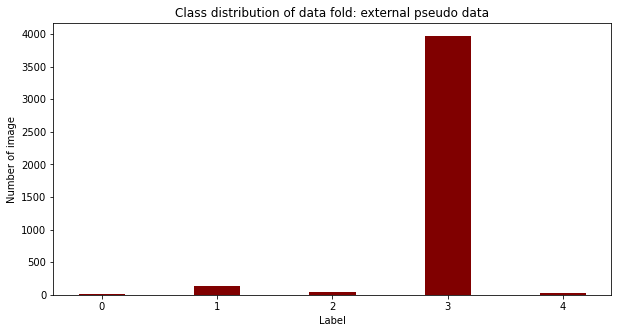

In [101]:
num_tta = len(test_transform_tta)
def pseudo_predict(loader, params, valid_test=False):
    count = 0
    preds = {'image_id':[],
             'label': []}
    model = declare_model(models_name[fold_model_index])
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(loader)
    models = []
#     for ckpt, weight in zip(fold_ckpt_index, fold_ckpt_weight):
#         state_dict = torch.load(WEIGHTS[ckpt])
#         fold_acc = state_dict["preds"]
#         print(f"Load pretrained model: {WEIGHTS[ckpt]} with acc: {fold_acc}")
#         model.load_state_dict(state_dict["model"])
#         models.append(model)
    print(f"Ensemble below models: {ensemble_models_name}")
    for name, ckpt in zip(ensemble_models_name, ensemble_ckpt_index):
        print(ckpt)
        m = declare_model(name, ckpt)  
        models.append(m)
        del m

    with torch.no_grad():
        for i, data in enumerate(stream, start=1):
            if params["visualize"]:
                visualize_tta(data, pred)
            tta_output = []   
            for i, image in enumerate(data["images"]):
                kfout = [torch.softmax(model(image), dim=1) for model in models]
                tta_output.extend(torch.stack(kfout, dim=0))
            tta_output = torch.stack(tta_output, dim=0).mean(dim=0)
            pred = torch.argmax(tta_output, dim=1).cpu().numpy()
            for j,p in enumerate(pred):
                if tta_output[j][p] > 0.8:
                    count+=1
                    preds['image_id'].append(data["image_ids"][0][j])
                    preds['label'].append(p)
    print(f"Total images pseudo from dataset: {count}")
    return preds
if create_pseudo:
    ## add external data
    test_external_dataset = TestDataset(test_external, transform=test_transform_tta, valid_test=True)
    test_external_loader = DataLoader(
        test_external_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=4, pin_memory=True,
    )  
    pred_test_external = pseudo_predict(test_external_loader, params, valid_test=True)
    pseudo = pd.DataFrame(pred_test_external)
    pseudo.to_csv(f'{root}/external/test_external_pseudo_0.8_round2.csv' ,index=False)
    visualize_class_dis(pseudo, 'external pseudo data')

#     #Val Train
#     pseudo_val_dataset = TestDataset(val_folds, transform=test_transform_tta, valid_test=True)
#     pseudo_val_loader = DataLoader(
#         pseudo_val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=4, pin_memory=True,
#     )  
#     pred_val_pseudo = pseudo_predict(pseudo_val_loader, model, params, valid_test=True)
#     pseudo = pd.DataFrame(pred_val_pseudo)
#     pseudo.to_csv(f'{root}/val_{params["fold"]}_pseudo.csv' ,index=False)


#     pseudo_train_dataset = TestDataset(train_folds, transform=test_transform_tta, valid_test=True)
#     pseudo_train_loader = DataLoader(
#         pseudo_train_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=4, pin_memory=True,
#     )  
#     pred_train_pseudo = pseudo_predict(pseudo_train_loader, model, params, valid_test=True)
#     pseudo = pd.DataFrame(pred_train_pseudo)
#     pseudo.to_csv(f'{root}/train_{params["fold"]}_pseudo.csv' ,index=False)

------------------------
## Make Test prediction w/wo Kfold check

In [ ]:
num_tta = len(test_transform_tta)
def test_predict(loader, model, params, valid_test=False):
    outputs = []
    model.eval()
    stream = tqdm(loader)
    models = []
    
    for ckpt, weight in zip(fold_ckpt_index, fold_ckpt_weight):
        state_dict = torch.load(WEIGHTS[ckpt])
        fold_acc = state_dict["preds"]
        print(f"Load pretrained model: {WEIGHTS[ckpt]} with acc: {fold_acc}")
        model.load_state_dict(state_dict["model"])
        models.append(model)
    
    with torch.no_grad():
        for i, data in enumerate(stream, start=1):
            if params["tta"]:
                ## TTA output
                tta_output = []   
                for i, image in enumerate(data["images"]):
                    kfout = [torch.softmax(model(image), dim=1) for model in models]
                    tta_output.extend(torch.stack(kfout, dim=0))
                tta_output = torch.stack(tta_output, dim=0).mean(dim=0)
                outputs.append(tta_output.argmax(1).cpu())
            else:
                data = data.to(params["device"], non_blocking=True)
                output = model(data)
                output = torch.softmax(output, dim = 1)
                outputs.append(output.argmax(1).cpu())
                
            if params["visualize"]:
                visualize_tta(data, pred)
                
    return outputs
# CV w/wo fold predict
final_out = test_predict(test_pred_loader, model, params, valid_test=True)
test['label'] = final_out 
test.to_csv('submission.csv', index=False)
test.head(n=10)

In [ ]:
# CV w/wo fold predict
def tta_test_ensemble_model(loader, models, params, valid_test=False):
    metric_monitor = MetricMonitor()
    stream = tqdm(loader)
    outputs = []
    models = []
    print(f"Ensemble below models: {ensemble_models_name}")
    for name, ckpt, weight in zip(ensemble_models_name, ensemble_ckpt_index, ensemble_ckpt_weight):
        m = declare_model(name, ckpt)  
        models.append(m)
        del m
    
    with torch.no_grad():
        for i, data in enumerate(stream, start=1):
            if params["visualize"]:
                visualize_tta(data, pred)
            tta_output = []   
            for i, image in enumerate(data["images"]):
                kfout = [torch.softmax(model(image), dim=1) for model in models]
                tta_output.extend(torch.stack(kfout, dim=0))
            tta_output = torch.stack(tta_output, dim=0).mean(dim=0)
            outputs.append(tta_output.argmax(1).cpu().numpy())
    return outputs

if params["ensemble"]:
    final_out_ensemble = tta_test_ensemble_model(test_pred_loader, models, params, valid_test=True)[0]
    
test['label'] = final_out_ensemble 
test.to_csv('submission.csv', index=False)
test.head(n=10)